In [1]:
%matplotlib notebook
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
%config InlineBackend.figure_format = 'svg'

from matplotlib.pyplot import*
from numpy import zeros, array,log,dot,sqrt,conjugate,real,imag,arange,transpose
from scipy.sparse.linalg import eigs
from scipy.linalg import eigh,eig,expm
from scipy.optimize import minimize
from copy import deepcopy
from time import time
import pickle
from scipy.sparse.linalg import eigs

All possible gauge invariant vertices

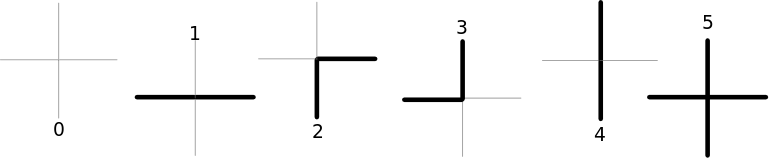

Illustration on how the interactions between vertices look like in our model of the scars. The letter F(A) between two links indicates that the their interaction is (anti-)ferromagnetic.

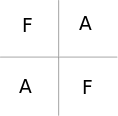

In [2]:
#We construct compatibility arrays.
##> compatibility_y[i,j] is 1(0) if it is (in)compatible to place the vertex j on top of i.
##> compatibility_x[i,j] is 1(0) if it is (in)compatible to place the vertex j to the right of i
### The vertex 6 is used as a place holder and, by construction, will be compatible with all vertices

compatibility_y=zeros((7,7),int)
compatibility_y[0,0]=1
compatibility_y[0,1]=1
compatibility_y[0,3]=1
compatibility_y[1,0]=1
compatibility_y[1,1]=1
compatibility_y[1,3]=1
compatibility_y[2,0]=1
compatibility_y[2,1]=1
compatibility_y[2,3]=1
compatibility_y[3,2]=1
compatibility_y[3,4]=1
compatibility_y[3,5]=1
compatibility_y[4,2]=1
compatibility_y[4,4]=1
compatibility_y[4,5]=1
compatibility_y[5,2]=1
compatibility_y[5,4]=1
compatibility_y[5,5]=1
compatibility_y[6,:]=1
compatibility_y[:,6]=1

compatibility_x=zeros((7,7),int)
compatibility_x[0,0]=1
compatibility_x[0,2]=1
compatibility_x[0,4]=1
compatibility_x[1,1]=1
compatibility_x[1,3]=1
compatibility_x[1,5]=1
compatibility_x[2,1]=1
compatibility_x[2,3]=1
compatibility_x[2,5]=1
compatibility_x[3,0]=1
compatibility_x[3,2]=1
compatibility_x[3,4]=1
compatibility_x[4,0]=1
compatibility_x[4,2]=1
compatibility_x[4,4]=1
compatibility_x[5,1]=1
compatibility_x[5,3]=1
compatibility_x[5,5]=1
compatibility_x[6,:]=1
compatibility_x[:,6]=1

In [3]:
#Observables associated with vertices

#Resulting energy from two links interactions from our model.
energy=zeros(6)
energy[2]=-4
energy[3]=-4

#Total magnetization of each time of vertex
mag=zeros(6)
mag[0]=-1
mag[5]=1

#The two winding direction contributions of each vertex

#Here we consider the value of the top-most vertical link
windings_y=zeros(6,int)+1
windings_y[0]=-1
windings_y[1]=-1
windings_y[2]=-1

#Here we consider the value of the right-most horizontal link
windings_x=zeros(6,int)+1
windings_x[0]=-1
windings_x[3]=-1
windings_x[4]=-1

In [4]:
#Construction of states by systematically checking the compatibility of adding
#a new vertex with the existing vertices. By construction, when we try to place 
#a vertex and certain neighbours have not yet been placed, this is is by construction
#always compatible we adding a new vertex.  

def construction_states(L1,L2):
    allowed=[zeros((L2,L1),int)+6]       #The value 6 working as a place holder
    for x in range(L1):
        for y in range(L2):
            new=[]
            for mat in allowed:
                for i in range(6):
                    condition = compatibility_x[i,mat[y,(x+1)%L1]]
                    condition*= compatibility_x[mat[y,(x-1)%L1],i]
                    condition*= compatibility_y[i,mat[(y+1)%L2,x]]
                    condition*= compatibility_y[mat[(y-1)%L2,x],i]
                    if condition==1:
                        state=deepcopy(mat)
                        state[y,x]=i
                        new+=[state]
            allowed=deepcopy(new)
    return allowed

#For obc we simply don't check the closing of the boundary
def construction_states_obc(L1,L2):
    allowed=[zeros((L2,L1),int)+6]
    for x in range(L1):
        for y in range(L2):
            new=[]
            for mat in allowed:
                for i in range(6):
                    condition=1
                    if x<L1-1:
                        condition*= compatibility_x[i,mat[y,(x+1)%L1]]
                    if x>0:
                        condition*= compatibility_x[mat[y,(x-1)%L1],i]
                    if y<L2-1:
                        condition*= compatibility_y[i,mat[(y+1)%L2,x]]
                    if y>0:
                        condition*= compatibility_y[mat[(y-1)%L2,x],i]
                    if condition==1:
                        state=deepcopy(mat)
                        state[y,x]=i
                        new+=[state]
            allowed=deepcopy(new)
    return allowed


#We associate two number to each state: M and m
###> M is obtained by flattening the state and then mapped to an integer by
#interpreting each 
def stts_to_dic(stts,L1,L2):
    M2m={}
    m2M={}
    for m,st in enumerate(stts):
        M=int(''.join(map(str,st.flatten())),6)
        m2M[m]=M
        M2m[M]=m
    return M2m, m2M

def winding_sector(wx,wy,stts,L1,L2):
    new_stts=[]
    for st in stts:
        w=sum([windings_x[st[y,0]] for y in range(L2)])
        if w==wy:
            w=sum([windings_y[st[0,x]] for x in range(L1)])
            if w==wx:
                new_stts+=[st]
    return new_stts

In [5]:
stts2_2 = construction_states(2,2)

In [21]:
stts8_2 = construction_states(8,2)

In [90]:
stts10_2 = construction_states(10,2)

In [71]:
stts6_4 = construction_states(6,4)

In [39]:
stts6_2 = construction_states(6,2)

In [73]:
stts14_2 = construction_states(14,2)

In [102]:
print(len(stts2_2),len(stts8_2),len(stts10_2),len(stts6_4),len(stts14_2))

18 7074 61098 98466 4815738


The image below shoes how the two flippable plaquettes can look like. For each of them, there are two possible vertices. When it flips, it goes to a well defined other vertex. For example: 1<->3, 2<->4 and so on.

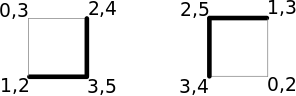

In [6]:
#The kinetic term
def Ok(L1,L2,stts,M2m,m2M):
    N=len(m2M)
    H=zeros((N,N),complex)
    base=array([2**i for i in range(L1*L2)])
    for i,st in enumerate(stts):
        for x in range(L1):
            for y in range(L2):
                if st[y,x] in [1,2] and st[(y+1)%L2,(x+1)%L1] in [2,4]:
                    st_new=zeros((L2,L1),int)+st
                    st_new[y,x]+=2
                    st_new[(y+1)%L2,(x+1)%L1]-=1
                    st_new[y,(x+1)%L1]-=3
                    st_new[(y+1)%L2,x]+=2
                    M=int(''.join(map(str,st_new.flatten())),6)
                    H[i,M2m[M]]=-1
                elif st[y,x] in [3,4] and st[(y+1)%L2,(x+1)%L1] in [1,3]:
                    st_new=zeros((L2,L1),int)+st
                    st_new[y,x]-=2
                    st_new[(y+1)%L2,(x+1)%L1]+=1
                    st_new[y,(x+1)%L1]+=3
                    st_new[(y+1)%L2,x]-=2
                    M=int(''.join(map(str,st_new.flatten())),6)
                    H[i,M2m[M]]=-1
    return H

In [7]:
#The potential term of our effective model
def Op_effective(L1,L2,stts,M2m,m2M):
    N=len(m2M)
    H=zeros((N,N),complex)
    base=array([2**i for i in range(L1*L2)])
    for i,st in enumerate(stts):
        for x in range(L1):
            for y in range(L2):
                H[i,i]+=energy[st[y,x]]
    return H

In [8]:
#The potential term of the original RK model
def Op(L1,L2,stts,M2m,m2M):
    N=len(m2M)
    H=zeros((N,N),complex)
    base=array([2**i for i in range(L1*L2)])
    for i,st in enumerate(stts):
        for x in range(L1):
            for y in range(L2):
                if st[y,x] in [1,2] and st[(y+1)%L2,(x+1)%L1] in [2,4]:
                    H[i,i]+=1
                elif st[y,x] in [3,4] and st[(y+1)%L2,(x+1)%L1] in [1,3]:
                    H[i,i]+=1
    return H

In [9]:
#Total magnetization of the system
def Elect(L1,L2,stts,M2m,m2M):
    N=len(m2M)
    H=zeros((N,N),complex)
    for i,st in enumerate(stts):
        for x in range(L1):
            for y in range(L2):
                H[i,i]+=mag[st[y,x]]/2
    return H

In [10]:
#Constructs a list of (diagonal) operator constituted by the sum of all the electric
#fields, for every x, along the y links.
#Useful to compute correlations between different lines, afterwards
def Eoperators(L1,L2,stts):
    N=len(stts)
    lst=[]
    for x in range(L1):
        lst+=[zeros((N,N))]
        for i,st in enumerate(stts):
            for y in range(L2):
                v=st[y,x]
                lst[-1][i,i]+=int(v>=3)-int(v<3)
    return lst

#Sum of the product of successive operators defined above
def Ecorr(L1,L2,stts):
    Es=Eoperators(L1,L2,stts)
    op=dot(Es[-1],Es[0])
    for x in range(L1-1):
        op+=dot(Es[x],Es[x+1])
    return op

In [11]:
#Shannon entropy defined for a given state
def shannon_st(st):
    s=0
    for a in st:
        if abs(a)>0.000000001:
            s-=abs(a**2)*log(abs(a**2))
    return s

In [22]:
M2m_8_2,m2M_8_2=stts_to_dic(stts8_2,8,2)

In [23]:
Ok82=Ok(8,2,stts8_2,M2m_8_2,m2M_8_2)
Op82=Op(8,2,stts8_2,M2m_8_2,m2M_8_2)

TypeError: 'numpy.ndarray' object is not callable

In [35]:
w82,v82=eigh(Ok82)

<IPython.core.display.Javascript object>


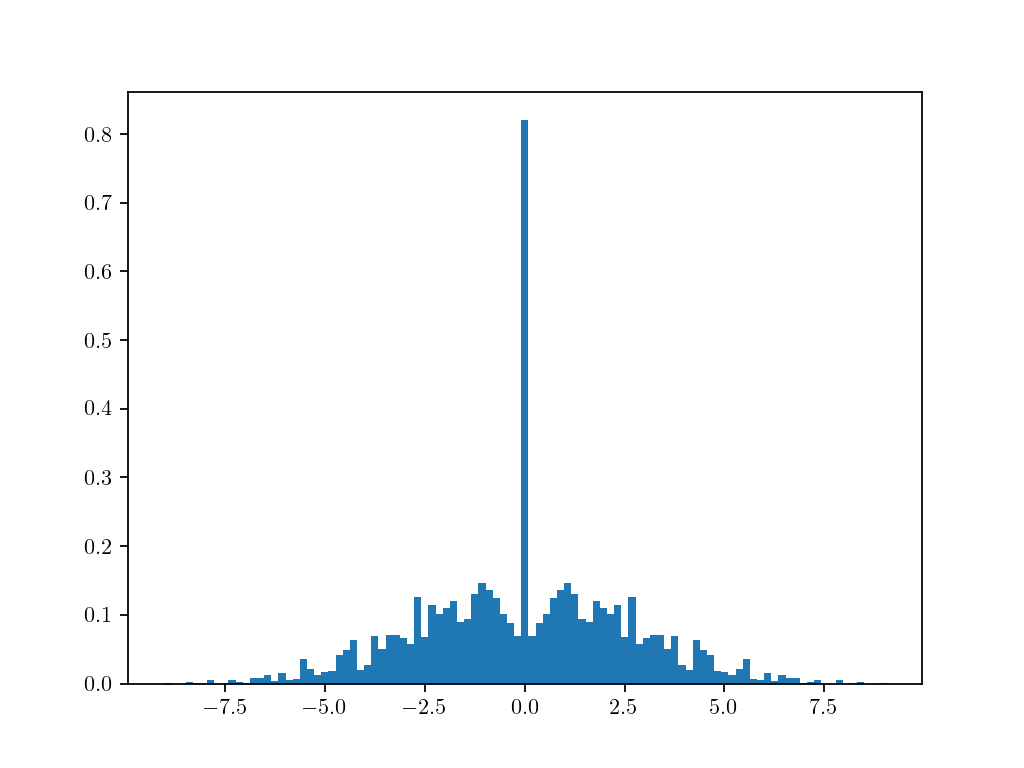

(array([7.89886691e-04, 0.00000000e+00, 0.00000000e+00, 2.36966007e-03,
        7.89886691e-04, 0.00000000e+00, 4.73932014e-03, 0.00000000e+00,
        0.00000000e+00, 4.73932014e-03, 1.57977338e-03, 7.89886691e-04,
        7.89886691e-03, 7.89886691e-03, 1.18483004e-02, 3.15954676e-03,
        1.57977338e-02, 4.73932014e-03, 7.10898022e-03, 3.63347878e-02,
        2.05370540e-02, 1.26381871e-02, 1.65876205e-02, 1.81673939e-02,
        4.18639946e-02, 4.89729748e-02, 6.31909353e-02, 1.89572806e-02,
        2.68561475e-02, 6.87201421e-02, 5.05527482e-02, 7.10898022e-02,
        7.10898022e-02, 6.63504820e-02, 5.76617284e-02, 1.26381871e-01,
        6.71403687e-02, 1.14533570e-01, 1.01105496e-01, 1.09794250e-01,
        1.20852664e-01, 8.92571961e-02, 9.32066295e-02, 1.30331304e-01,
        1.46918924e-01, 1.36650397e-01, 1.24012210e-01, 1.01895383e-01,
        8.84673094e-02, 6.95100288e-02, 8.19902385e-01, 6.95100288e-02,
        8.84673094e-02, 1.01895383e-01, 1.24012210e-01, 1.366503

In [45]:
hist(w82,bins=101,density=True)

In [46]:
w,v=eigh(Ok82-Op82)

In [83]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


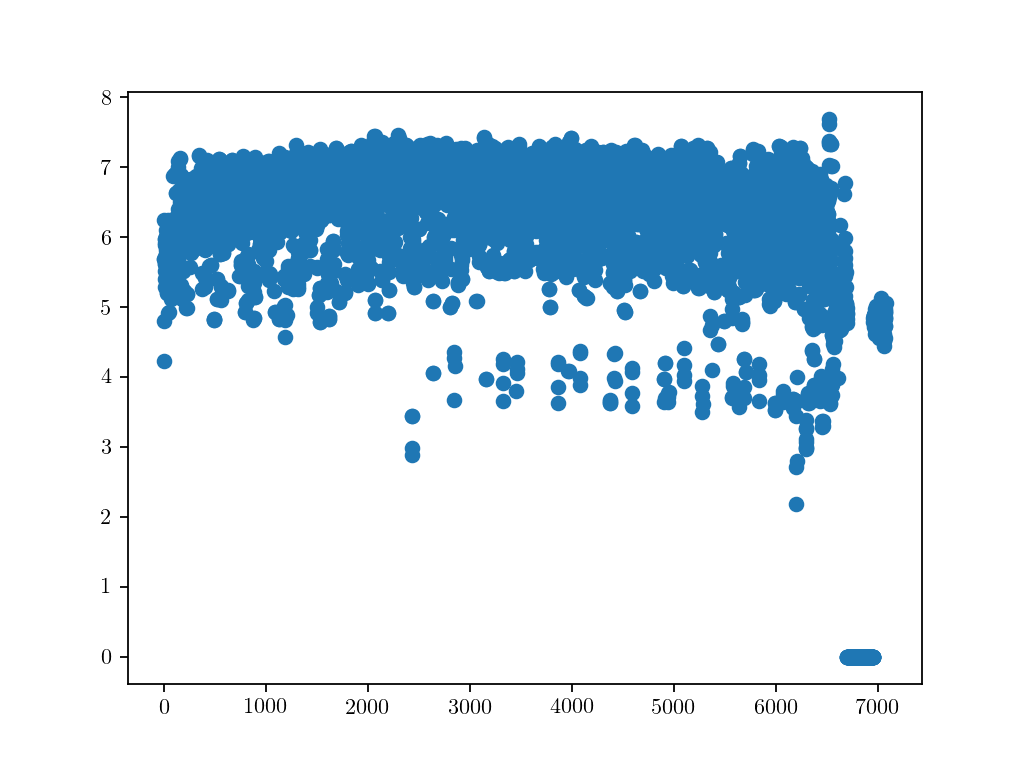

In [85]:
plot(range(len(sh)),sh,'o')

In [16]:
w00=winding_sector(0,0,stts8_2,8,2)

In [17]:
M2m_00,m2M_00=stts_to_dic(w00,8,2)

In [18]:
Ok82_00=Ok(8,2,w00,M2m_00,m2M_00)
Op82_00=Op(8,2,w00,M2m_00,m2M_00)

In [19]:
Os82_00=Op(8,2,w00,M2m_00,m2M_00)

In [113]:
w,v=eigh(Ok82_00-Op82_00)

In [114]:
ws,vs=eigh(Ok82_00-.5*Os82_00)

In [24]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

In [39]:
shs=[shannon_st(vs[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


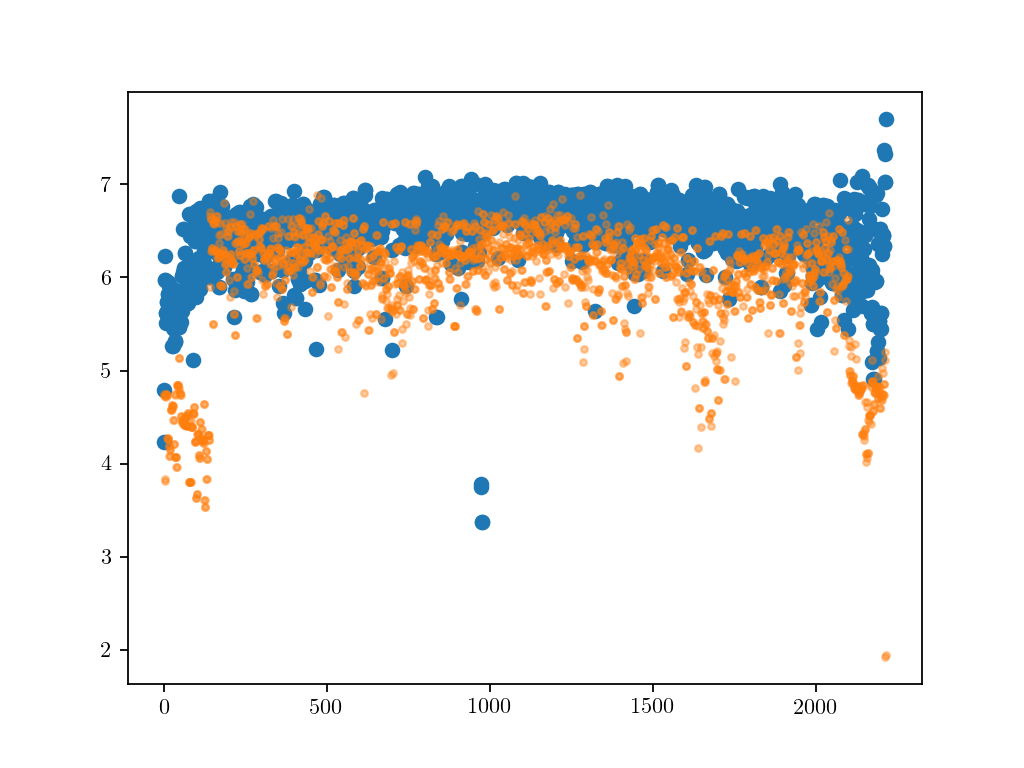

In [99]:
plot(range(len(sh)),sh,'o')
plot(range(len(shs)),shs,'.',alpha=.4)

In [109]:
Ecorr_op=Ecorr(8,2,w00)

In [115]:
ecorrs=[dot(conjugate(v[:,i]),dot(Ecorr_op,v[:,i])) for i in range(len(v))]

In [118]:
ecorrs_sim=[dot(conjugate(vs[:,i]),dot(Ecorr_op,vs[:,i])) for i in range(len(v))]

<IPython.core.display.Javascript object>


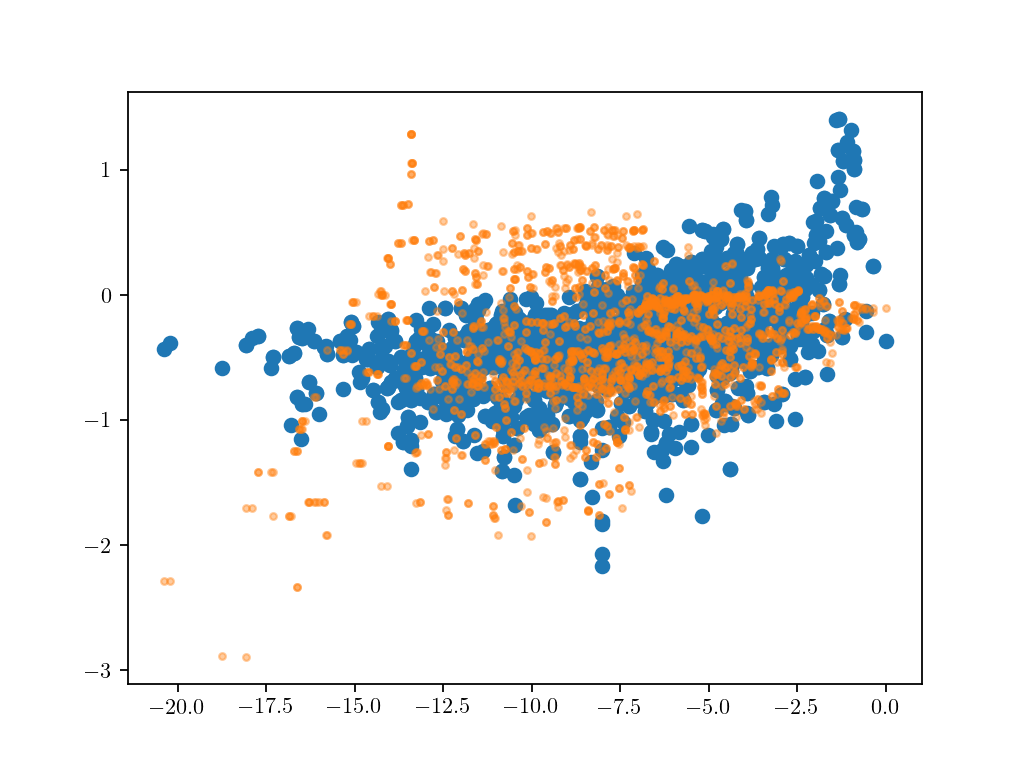

In [120]:
plot(w,real(ecorrs)/8,'o')
plot(w,real(ecorrs_sim)/8,'.',alpha=.4)

In [ ]:
base=array([2**i for i in range(16)])
evol1=[]
evol_s1=[]
evol2=[]
evol_s2=[]
st1_arr=zeros((8,2),int)
for i in range(0,8,2):
    st1_arr[i+1,0]=4
    st1_arr[i,1]=1
    st1_arr[i+1,1]=5
M=dot(base,st1_arr.flatten())
m=M2m_00[M]
st1=zeros(len(M2m_00),complex)
st1[m]=1
st2=dot(Ok82_00,st1)
st1_s=deepcopy(st1)
st2_s=deepcopy(st2)
for t in arange(0,33,3):
    U=expm(-1.j*t*(Ok-Op))
    st1=dot(U,st1)
    st2=dot(U,st2)
    evol1+=[dot(conjugate(st1),dot(Ecorr_o,st1))]
    evol2+=[dot(conjugate(st2),dot(Ecorr_o,st2))]
    U=expm(-1.j*t*(Ok-Os))
    st1_s=dot(U,st1_s)
    st2_s=dot(U,st2_s)
    evol_s1+=[dot(conjugate(st1),dot(Ecorr_o,st1))]
    evol_s2+=[dot(conjugate(st2),dot(Ecorr_o,st2))]

In [76]:
elect=Elect(8,2,w00,M2m_00,m2M_00)

In [77]:
elect2=dot(elect,elect)

In [20]:
rk=[]
si=[]
scrk=[]
scsi=[]
t0=time()
for lamb in arange(-2.,2.1,.04):
    w,v=eigh(Ok82_00-lamb*Op82_00)
    rk+=[w[1]-w[0]]
    #scrk+=[dot(conjugate(v[:,0]),dot(elect2,v[:,0]))-dot(conjugate(v[:,0]),dot(elect,v[:,0]))**2]
    w,v=eigh(Ok82_00-lamb*Os82_00)
    si+=[w[1]-w[0]]
    #scsi+=[dot(conjugate(v[:,0]),dot(elect2,v[:,0]))-dot(conjugate(v[:,0]),dot(elect,v[:,0]))**2]
print(time()-t0)

KeyboardInterrupt: 

In [21]:
len(rk)

102

In [20]:
#file = open('gap8x2', 'wb')
#pickle.dump(rk,file)
#pickle.dump(si,file)
#file.close()
file = open('gap8x2','rb')
rk=pickle.load(file)
si=pickle.load(file)
file.close()

In [21]:
rk=rk[:-1]

In [16]:
arange(-2.,2.02,.04)

2.0000000000000036

In [123]:
for lamb in arange(2.1,3.1,.02):
    w,v=eigh(Ok82_00-lamb*Op82_00)
    rk+=[w[1]-w[0]]
    #scrk+=[dot(conjugate(v[:,0]),dot(elect2,v[:,0]))-dot(conjugate(v[:,0]),dot(elect,v[:,0]))**2]
    w,v=eigh(Ok82_00-lamb*Os82_00)
    si+=[w[1]-w[0]]
    #scsi+=[dot(conjugate(v[:,0]),dot(elect2,v[:,0]))-dot(conjugate(v[:,0]),dot(elect,v[:,0]))**2]

<IPython.core.display.Javascript object>


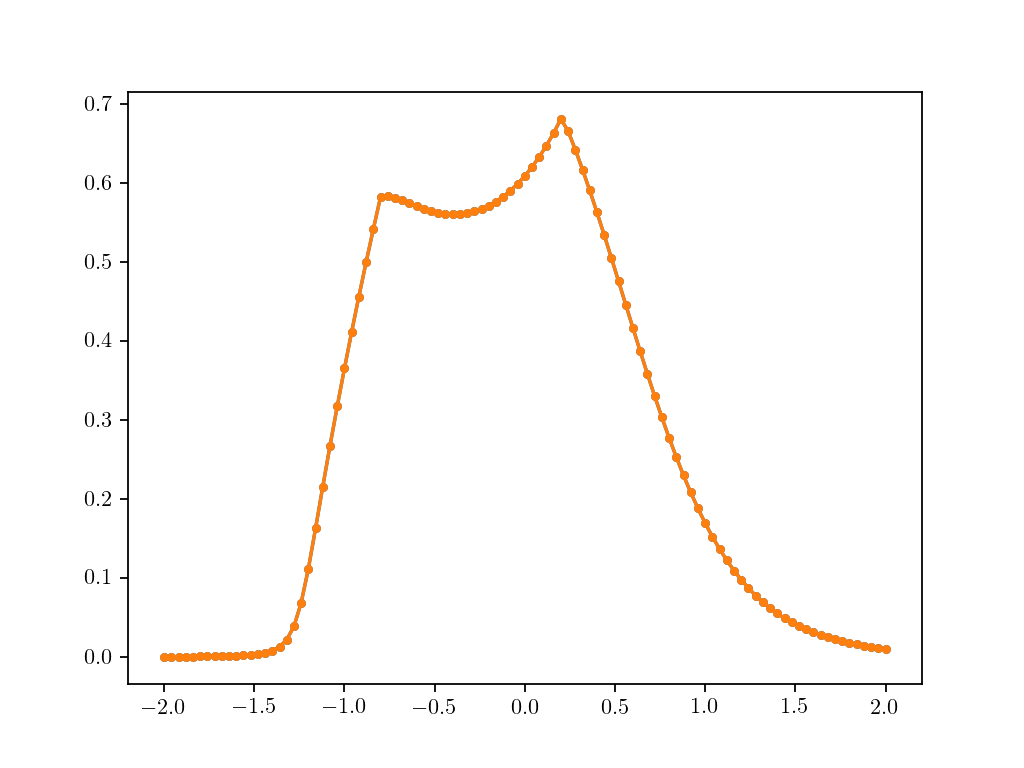

In [22]:
xx=arange(-2.,2.01,.04)
plot(xx,rk,'.-')
plot(xx,si,'.-')

<IPython.core.display.Javascript object>


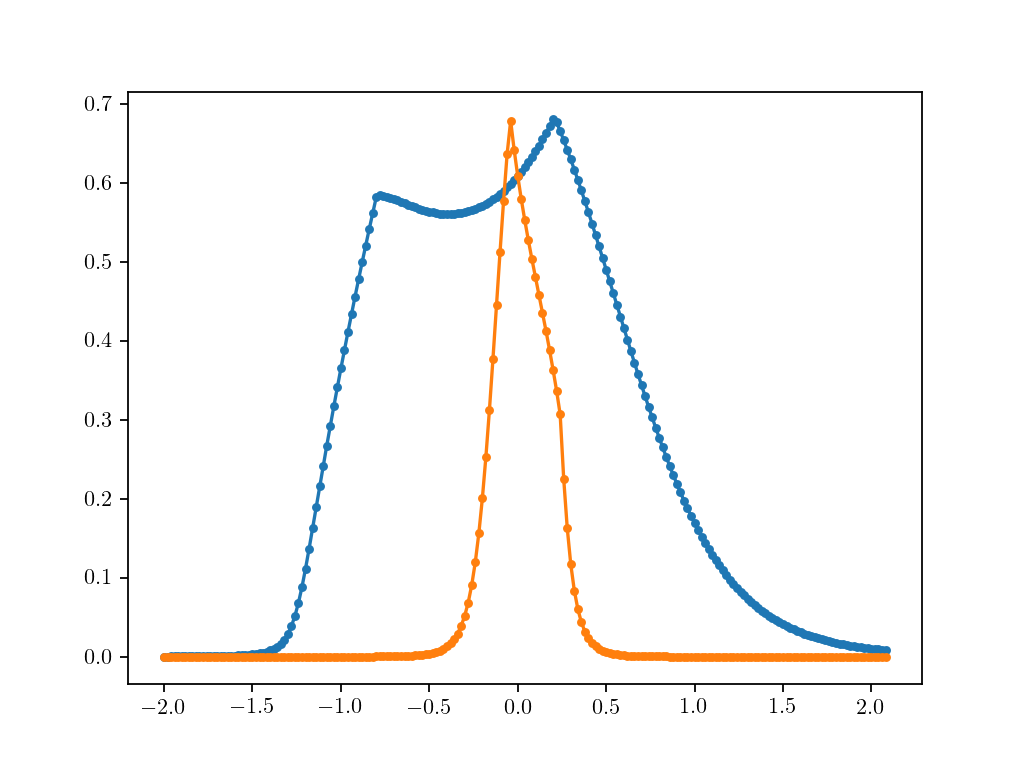

In [95]:
xx=arange(-2.,2.1,.02)
plot(xx,rk,'.-')
plot(xx,si,'.-')

<IPython.core.display.Javascript object>


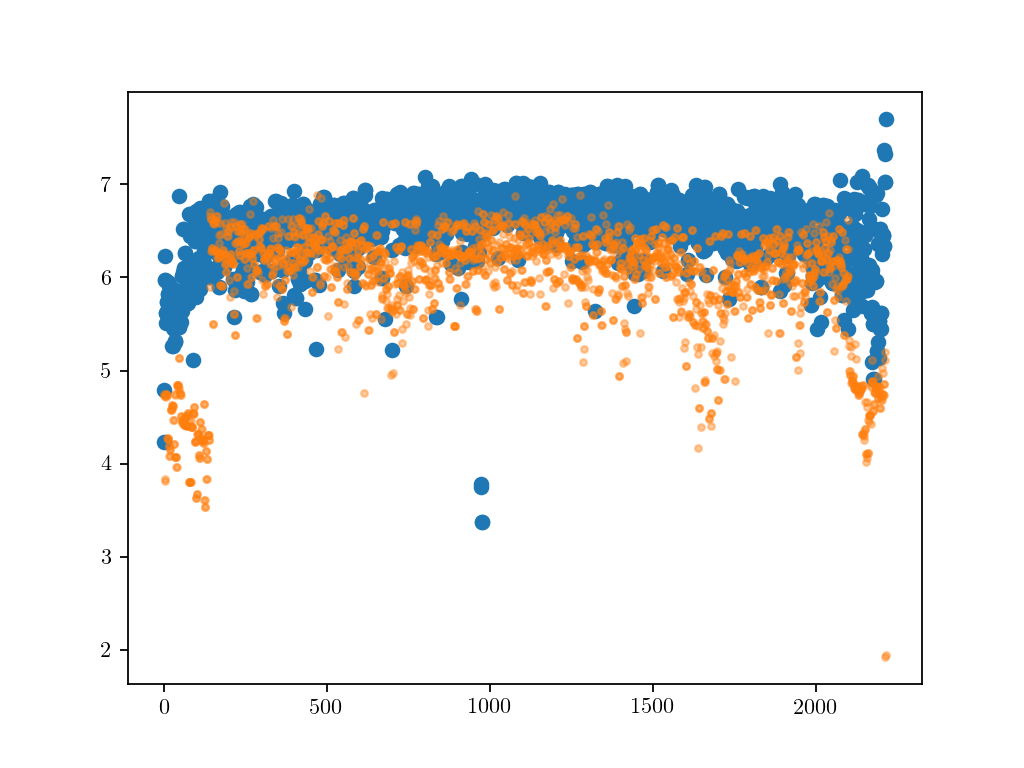

ValueError: x and y must have same first dimension, but have shapes (205,) and (0,)

In [96]:
plot(xx,real(scrk),'.-')
plot(xx,real(scsi),'.-')

In [88]:
dot(conjugate(v[:,0]),dot(elect2,v[:,0]))

0j

In [91]:
for x in range(len(elect[:,0])):
    for y in range(len(elect[0,:])):
        if abs(elect[x,y])>.0001:
            print(x,y,elect[x,y])

In [63]:
w

array([-9.03777503+1.62720128e-17j, -8.42909449+3.69973215e-17j])

In [65]:
lamb=0
w,v=eigs(Ok82_00-lamb*Os82_00,k=2,which='SR')

In [58]:
w

array([ 9.03777503+1.46972457e-18j, -9.03777503+6.12473847e-18j])

In [ ]:
sum(Op82[:,7064])

In [80]:
sum(Op82[:,7064])

0j

In [68]:
for i,x in enumerate(Ok82[:,6944]):
    if abs(x)>.01:
        print(i,x)

3536 (-1+0j)
6943 (-1+0j)


In [82]:
stts8_2[7064]

array([[5, 5, 5, 5, 1, 5, 5, 1],
       [5, 5, 5, 5, 1, 5, 5, 1]])

In [69]:
stts8_2[3536]

array([[2, 5, 5, 5, 5, 5, 5, 3],
       [3, 4, 4, 4, 4, 4, 4, 2]])

In [70]:
stts8_2[6943]

array([[5, 5, 5, 5, 5, 5, 3, 2],
       [4, 4, 4, 4, 4, 4, 2, 3]])

In [84]:
M2m_10_2,m2M_10_2=stts_to_dic(stts10_2,10,2)

In [16]:
M2m_8_2,m2M_8_2=stts_to_dic(stts8_2,8,2)

In [103]:
M2m_2_2,m2M_2_2=stts_to_dic(stts2_2,2,2)

In [17]:
Ok82=Ok(8,2,stts8_2,M2m_8_2,m2M_8_2)
Op82=Op(8,2,stts8_2,M2m_8_2,m2M_8_2)

NameError: name 'H' is not defined

<IPython.core.display.Javascript object>


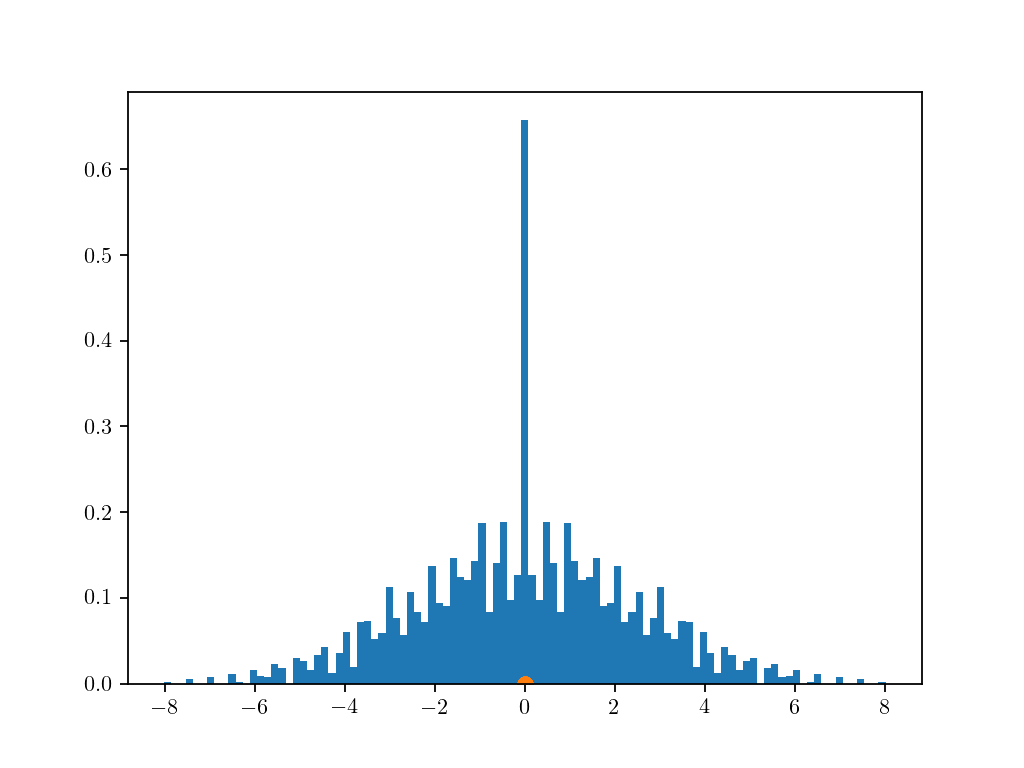

(array([0.00178016, 0.        , 0.        , 0.00534047, 0.        ,
        0.        , 0.00712063, 0.        , 0.        , 0.01068094,
        0.00178016, 0.        , 0.01602141, 0.00890078, 0.00712063,
        0.02314203, 0.01780156, 0.        , 0.03026266, 0.02670235,
        0.01602141, 0.03382297, 0.04272375, 0.01246109, 0.03560313,
        0.06052532, 0.01958172, 0.07120625, 0.07298641, 0.05162453,
        0.05874516, 0.11214985, 0.07654672, 0.056965  , 0.10680938,
        0.08366735, 0.07120625, 0.13707204, 0.09434829, 0.09078797,
        0.14597282, 0.12461094, 0.12105063, 0.14241251, 0.18691642,
        0.08366735, 0.14063235, 0.18869657, 0.0979086 , 0.1263911 ,
        0.65687769, 0.1263911 , 0.0979086 , 0.18869657, 0.14063235,
        0.08366735, 0.18691642, 0.14241251, 0.12105063, 0.12461094,
        0.14597282, 0.09078797, 0.09434829, 0.13707204, 0.07120625,
        0.08366735, 0.10680938, 0.056965  , 0.07654672, 0.11214985,
        0.05874516, 0.05162453, 0.07298641, 0.07

In [129]:
hist(w,bins=101,density=True)

In [19]:
w,v=eigh(Ok82-Op82)

In [22]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


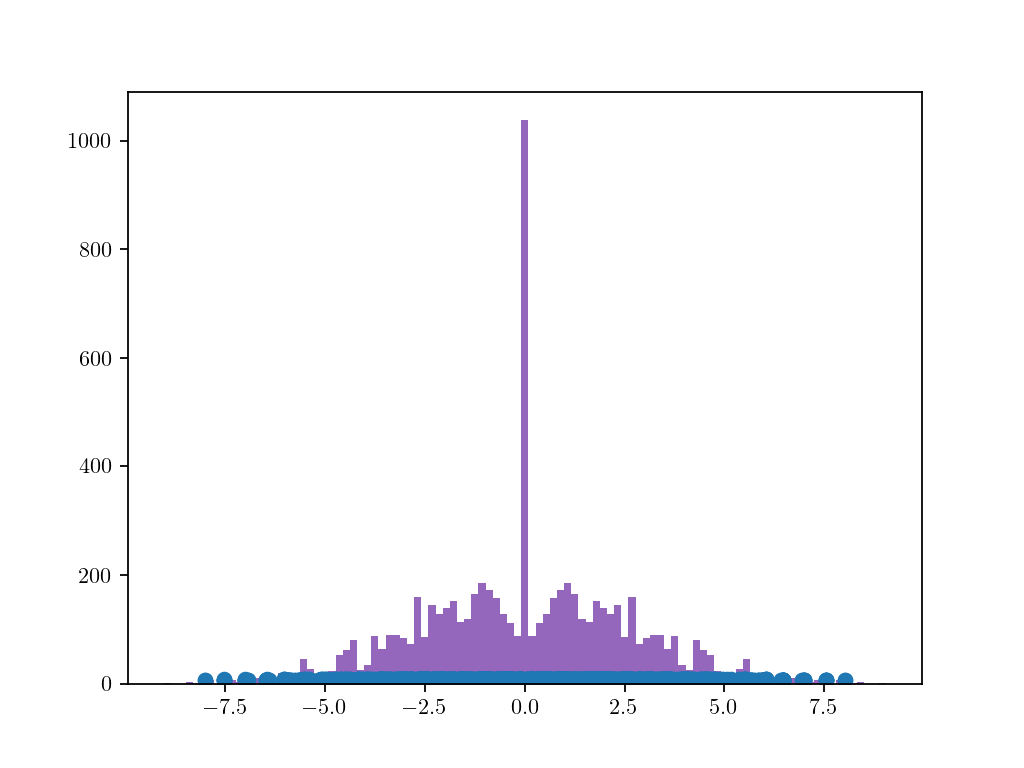

In [26]:
plot(w,sh,'o')

In [27]:
for i,s in enumerate(sh):
    if s<1:
        break
print(i)

3408


In [154]:
plot(range(len(w)),abs(v[:,3408]),'o-')

In [2]:
#file = open('8x2', 'wb')
#pickle.dump(w,file)
#pickle.dump(v,file)
#file.close()
file = open('8x2','rb')
w=pickle.load(file)
v=pickle.load(file)
file.close()

<IPython.core.display.Javascript object>


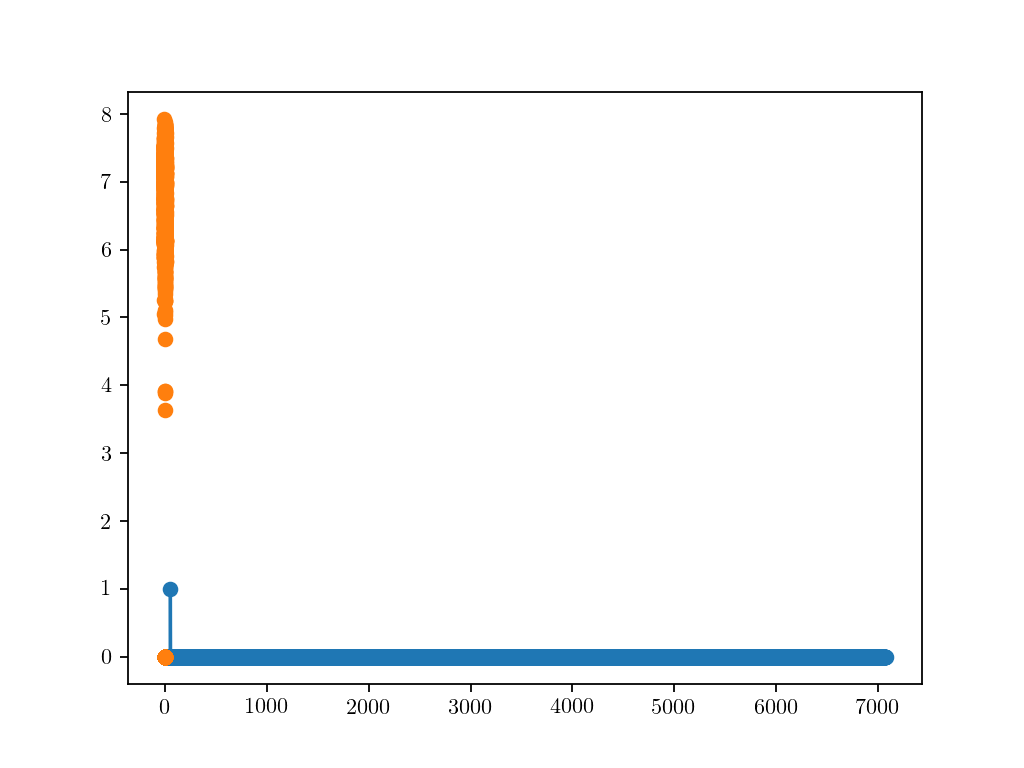

In [3]:
plot(range(len(w)),abs(v[:,3408]),'o-')

In [8]:
stts=construction_states(8,2)
M2m,m2M=stts_to_dic(stts,8,2)

In [9]:
stts[3408]

array([[2, 5, 3, 4, 4, 2, 3, 0],
       [3, 4, 2, 5, 5, 3, 2, 1]])

In [31]:
sum(Op82[:,3048])

0j

In [3]:
def add_site_dimer_ladder(st):
    n=st[-1]
    lst=[]
    if n==1:
        lst=[st+[2]]
    else:
        lst=[st+[0],st+[1]]
    return lst

In [4]:
def st_2_M_dimer_ladder(st):
    return int(''.join(map(str,st)),3)

In [5]:
def build_states_dimer_ladder(L):
    M2m={}
    st_lst=[[0],[1],[2]]
    for i in range(L-1):
        new_lst=[]
        for st in st_lst:
            new_lst+=add_site_dimer_ladder(st)
        st_lst=deepcopy(new_lst)
    count=0
    for st in st_lst:
        M2m[st_2_M_dimer_ladder(st)]=count
        count+=1
    return new_lst,M2m

In [18]:
def Hamiltonian_dimer_ladder(L,st_lst,M2m):
    N=len(st_lst)
    H=zeros((N,N))
    for i,st in enumerate(st_lst):
        #Boundary terms
        if st[0] in [0,2]:
            new_st=[[0,2][int(st[0]==0)]]+st[1:]
            j=M2m[st_2_M_dimer_ladder(new_st)]
            H[j,i]=-1
        if st[-1] in [0,1] and L%2==0:
            new_st=st[:-1]+[[0,1][int(st[0]==0)]]
            j=M2m[st_2_M_dimer_ladder(new_st)]
            H[j,i]=-1
        elif st[-1] in [0,2] and L%2==1:
            new_st=st[:-1]+[[0,2][int(st[0]==0)]]
            j=M2m[st_2_M_dimer_ladder(new_st)]
            H[j,i]=-1
        #Bulk terms
        for j,n in enumerate(st[:-1]):
            if st[j:j+2] in [[0,0],[1,2]]:
                new_st=st[:j]+[[0,0],[1,2]][int(st[j]==0)]+st[j+2:]
                j=M2m[st_2_M_dimer_ladder(new_st)]
                H[j,i]=-1
    return H

def potential_dimer_ladder(L,st_lst):
    N=len(st_lst)
    H=zeros((N,N))
    for i,st in enumerate(st_lst):
        #Boundary terms
        if st[0] in [0,2]:
            H[i,i]+=1
        if st[-1] in [0,1] and L%2==0:
            H[i,i]+=1
        elif st[-1] in [0,2] and L%2==1:
            H[i,i]+=1
        #Bulk terms
        for j,n in enumerate(st[:-1]):
            if st[j:j+2] in [[0,0],[1,2]]:
                H[i,i]+=1
    return H

In [19]:
L=4
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)

In [20]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


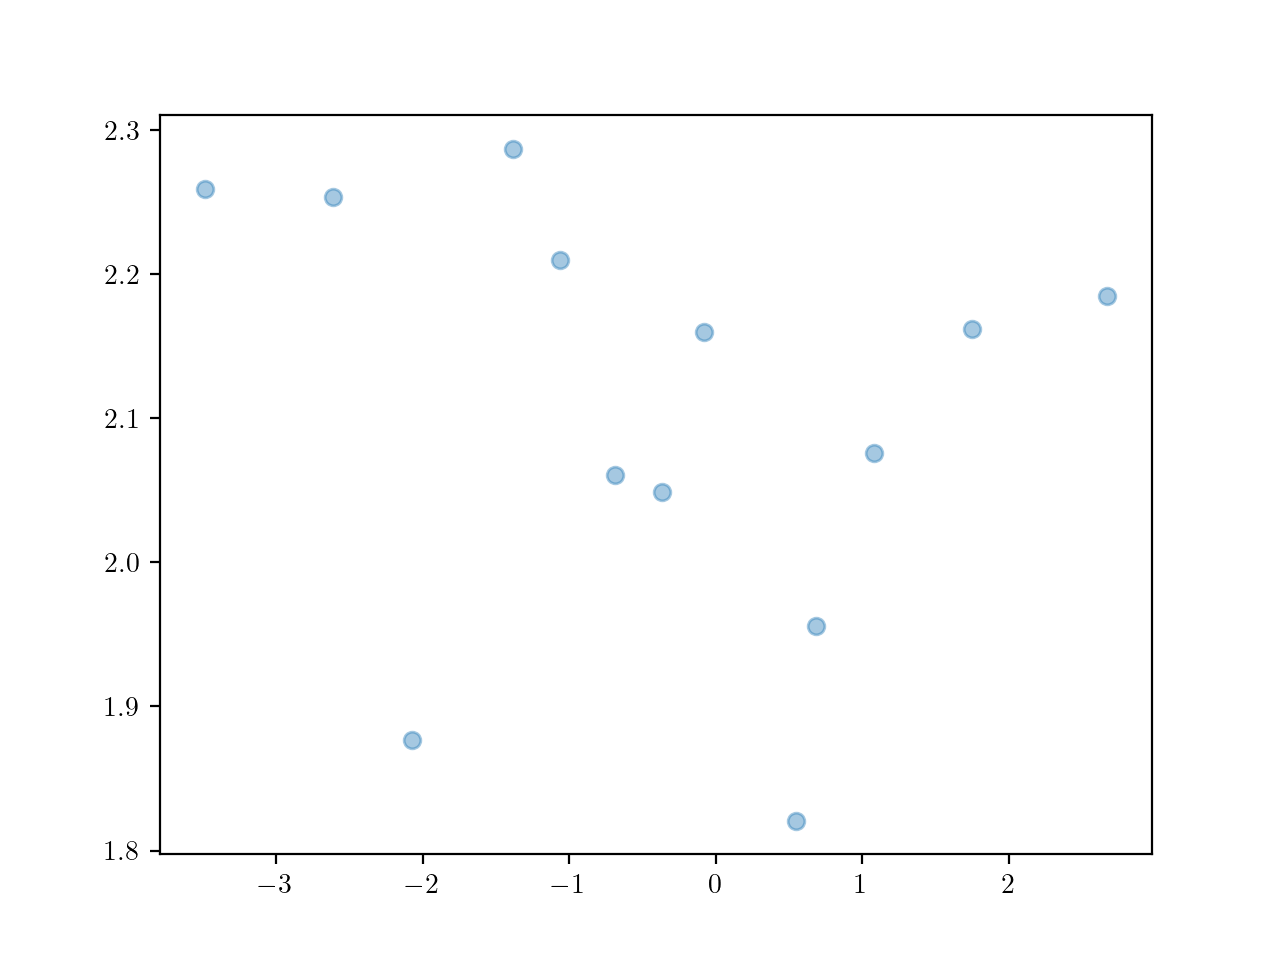

In [22]:
plot(w,sh,'o',alpha=.4)

In [23]:
L=16
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)

In [24]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


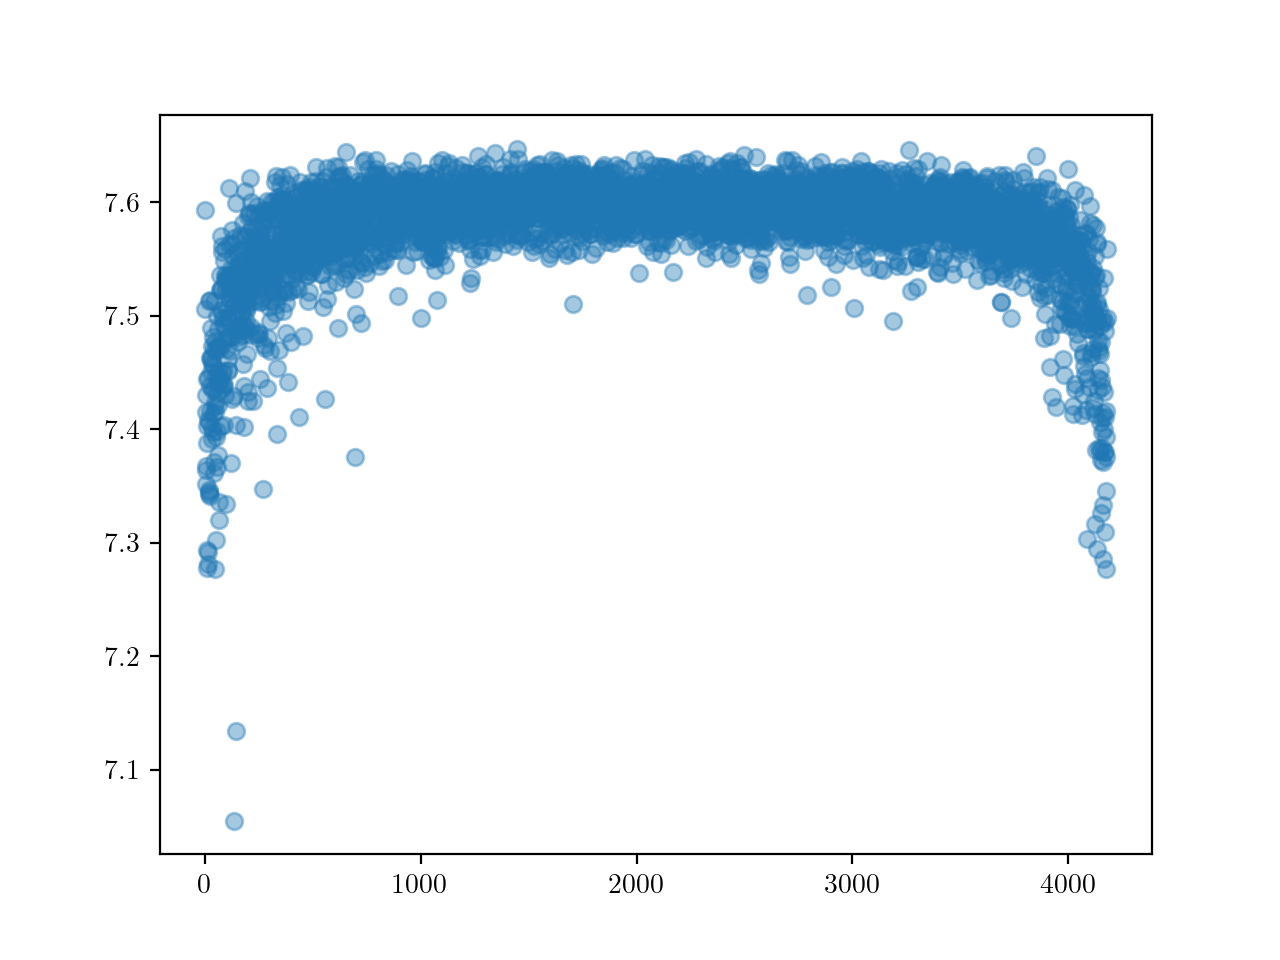

In [25]:
plot(range(len(sh)),sh,'o',alpha=.4)

In [26]:
L=16
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)+.5*potential_dimer_ladder(L,st_lst)

In [27]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


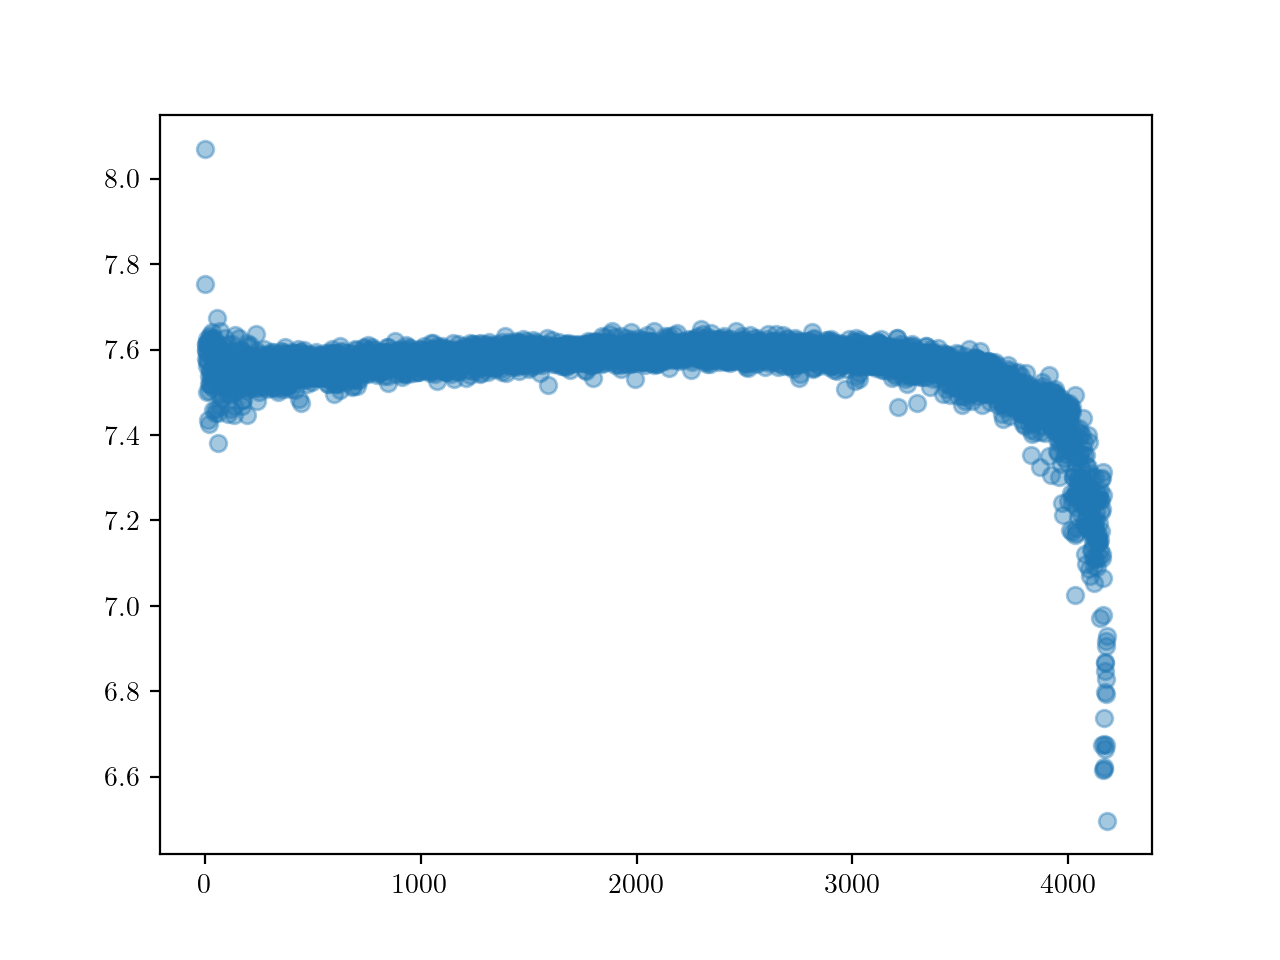

In [28]:
plot(range(len(sh)),sh,'o',alpha=.4)

In [29]:
L=16
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)+.1*potential_dimer_ladder(L,st_lst)

In [30]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


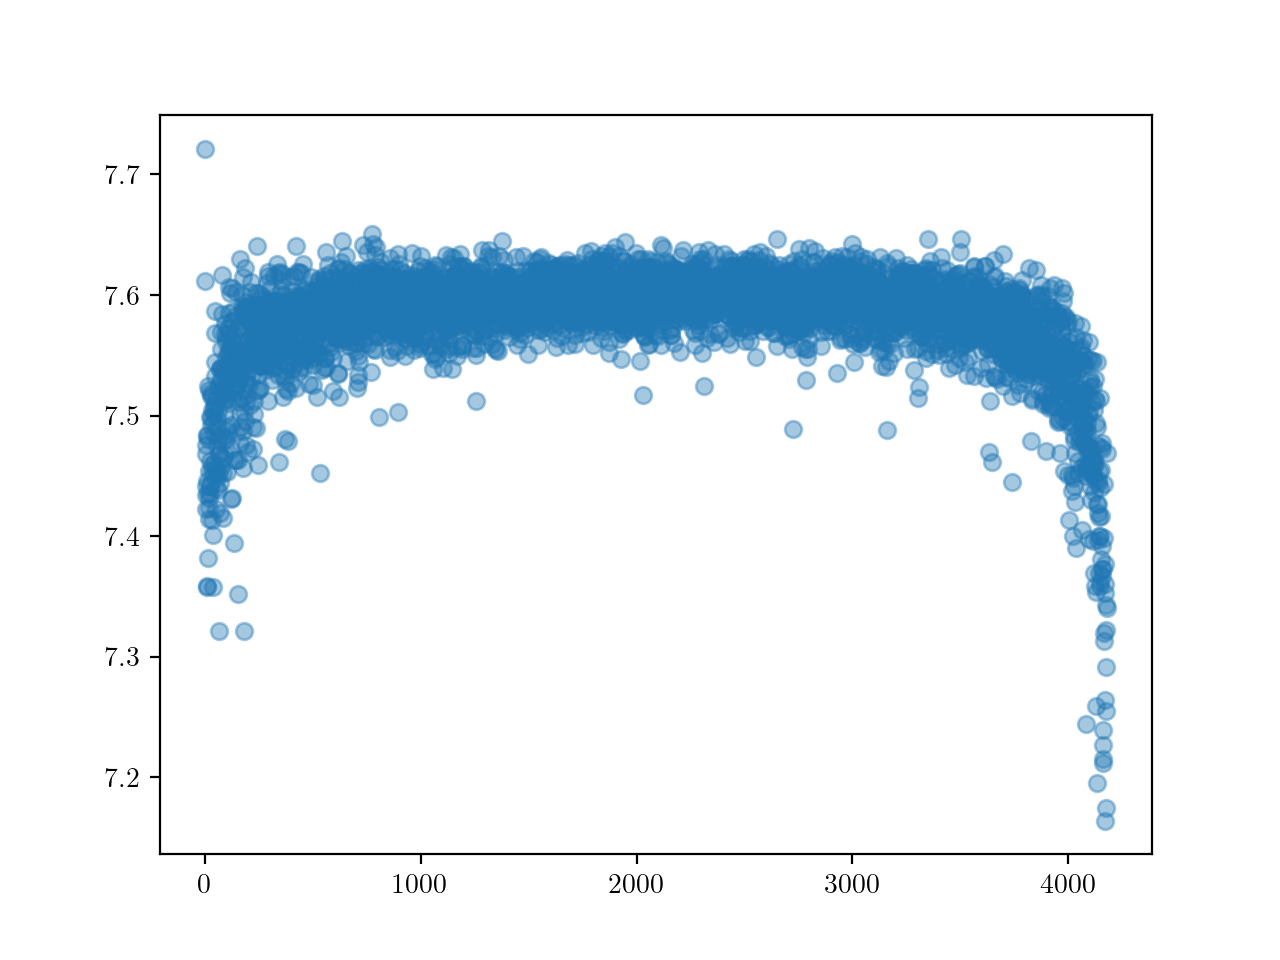

In [31]:
plot(range(len(sh)),sh,'o',alpha=.4)

In [32]:
L=16
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)-.1*potential_dimer_ladder(L,st_lst)

In [33]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


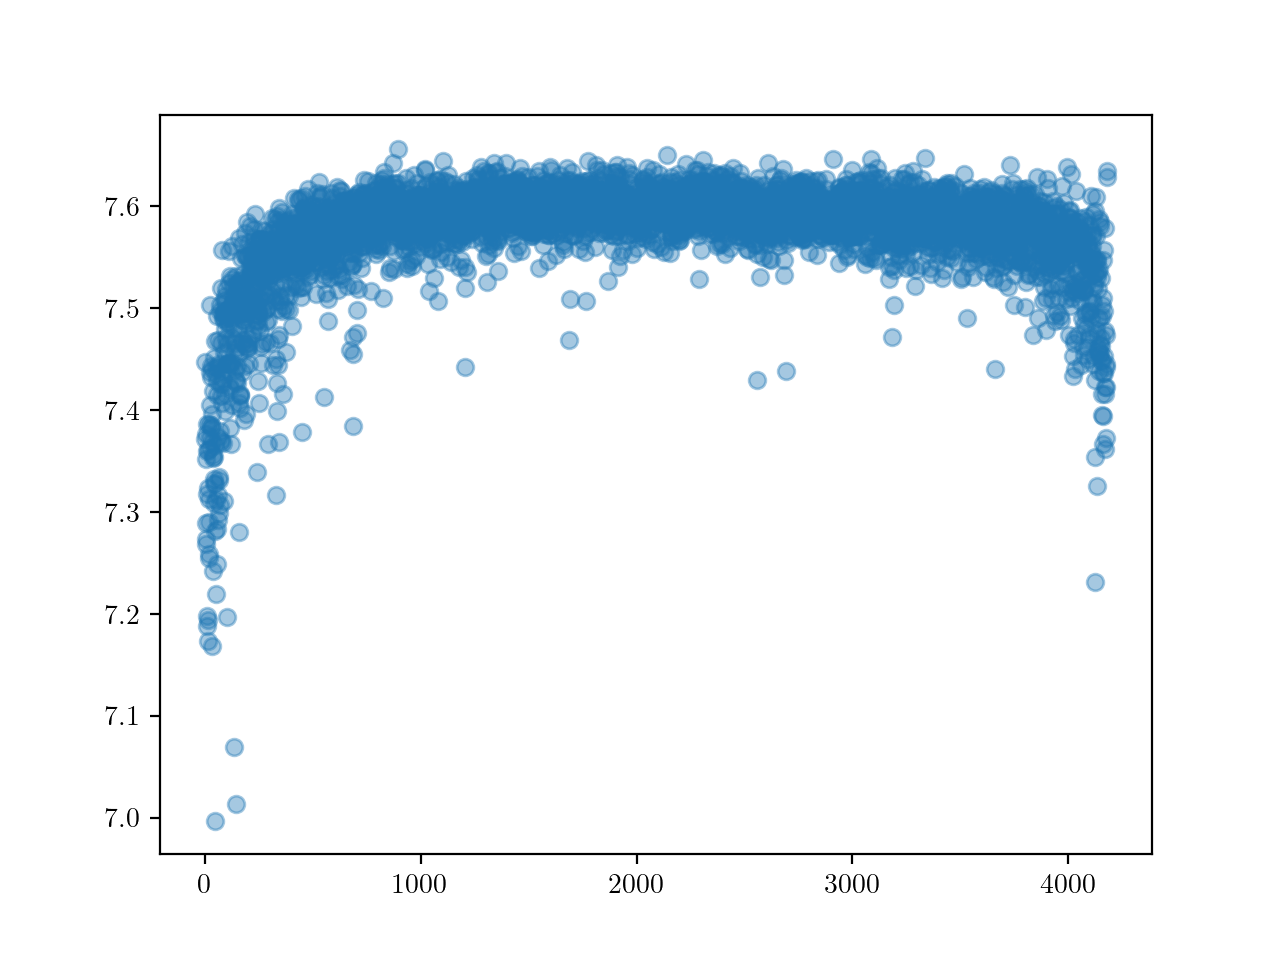

In [34]:
plot(range(len(sh)),sh,'o',alpha=.4)

In [28]:
stts4_2 = construction_states(4,2)

In [31]:
M2m,m2M=stts_to_dic(stts4_2,4,2)

In [32]:
Ok42=Ok(4,2,stts4_2,M2m,m2M)
Op42=Op(4,2,stts4_2,M2m,m2M)

In [33]:
w,v=eigh(Ok42-0.1*Op42)

In [34]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


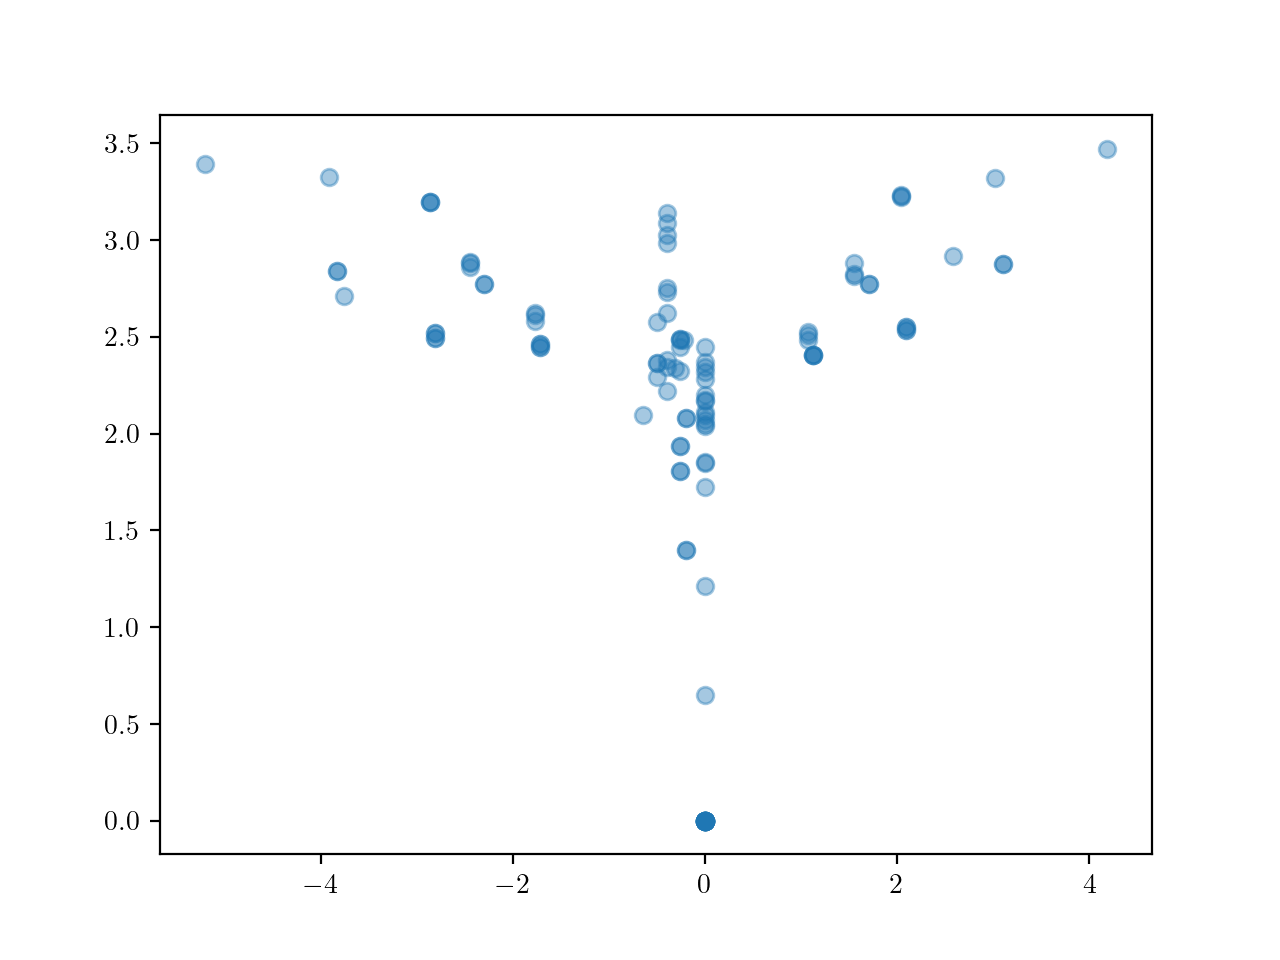

In [35]:
plot(w,sh,'o',alpha=.4)

<IPython.core.display.Javascript object>


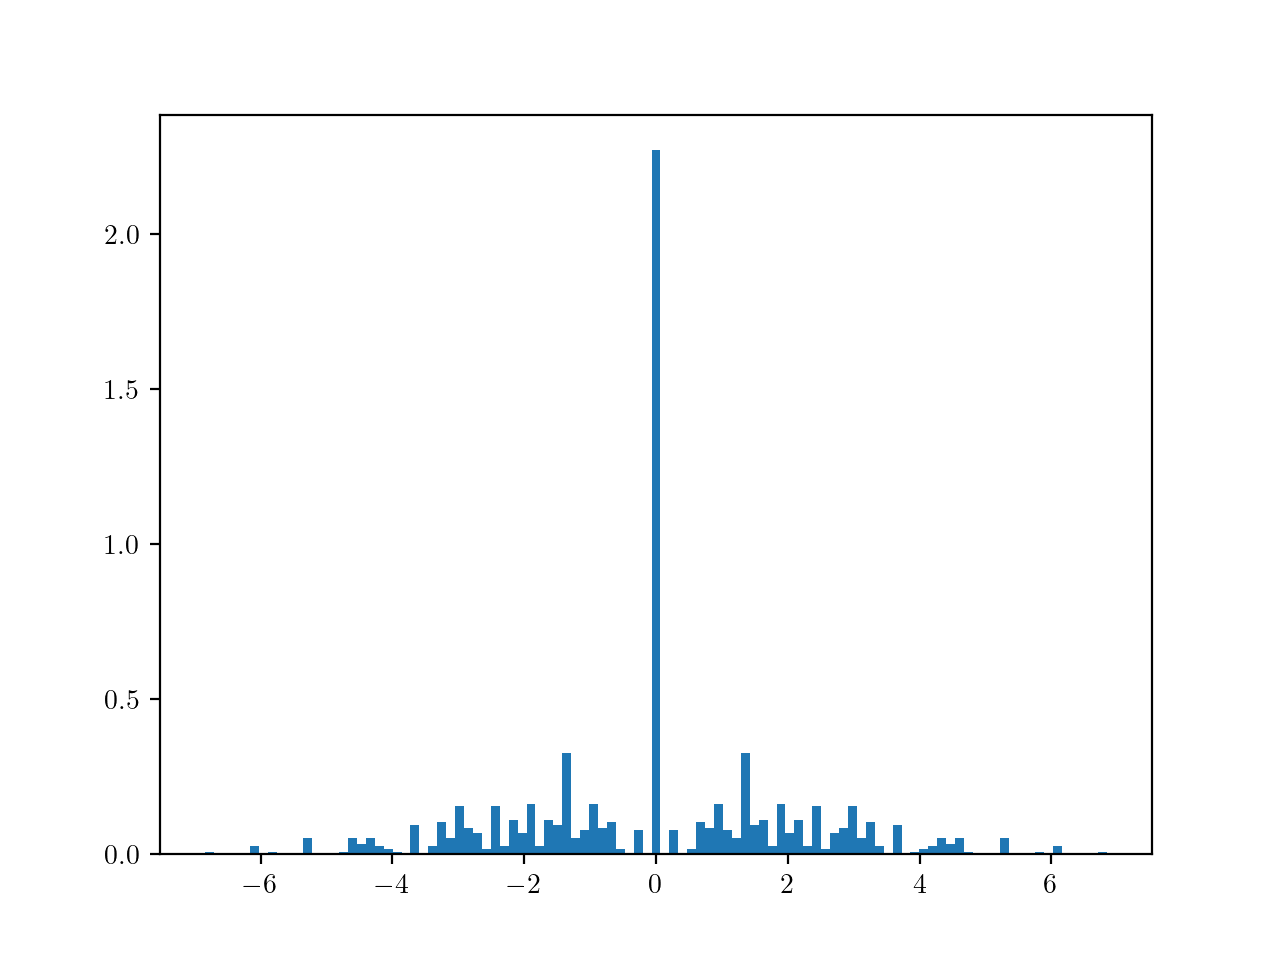

(array([0.00860144, 0.        , 0.        , 0.        , 0.        ,
        0.02580431, 0.        , 0.00860144, 0.        , 0.        ,
        0.        , 0.05160863, 0.        , 0.        , 0.        ,
        0.00860144, 0.05160863, 0.03440575, 0.05160863, 0.02580431,
        0.01720288, 0.00860144, 0.        , 0.09461581, 0.        ,
        0.02580431, 0.10321725, 0.05160863, 0.15482588, 0.08601438,
        0.0688115 , 0.01720288, 0.15482588, 0.02580431, 0.11181869,
        0.0688115 , 0.16342731, 0.02580431, 0.11181869, 0.09461581,
        0.32685463, 0.05160863, 0.07741294, 0.16342731, 0.08601438,
        0.10321725, 0.01720288, 0.        , 0.07741294, 0.        ,
        2.27077952, 0.        , 0.07741294, 0.        , 0.01720288,
        0.10321725, 0.08601438, 0.16342731, 0.07741294, 0.05160863,
        0.32685463, 0.09461581, 0.11181869, 0.02580431, 0.16342731,
        0.0688115 , 0.11181869, 0.02580431, 0.15482588, 0.01720288,
        0.0688115 , 0.08601438, 0.15482588, 0.05

In [22]:
hist(w,bins=101,density=True)

In [47]:
stts2_2

[array([[0, 0],
        [0, 0]]),
 array([[0, 4],
        [0, 4]]),
 array([[0, 0],
        [1, 1]]),
 array([[0, 4],
        [1, 5]]),
 array([[1, 1],
        [0, 0]]),
 array([[1, 5],
        [0, 4]]),
 array([[1, 1],
        [1, 1]]),
 array([[1, 5],
        [1, 5]]),
 array([[2, 3],
        [3, 2]]),
 array([[3, 2],
        [2, 3]]),
 array([[4, 0],
        [4, 0]]),
 array([[4, 4],
        [4, 4]]),
 array([[4, 0],
        [5, 1]]),
 array([[4, 4],
        [5, 5]]),
 array([[5, 1],
        [4, 0]]),
 array([[5, 5],
        [4, 4]]),
 array([[5, 1],
        [5, 1]]),
 array([[5, 5],
        [5, 5]])]

In [48]:
M2m,m2M=stts_to_dic(stts2_2,2,2)

In [49]:
Ok22=Ok(2,2,stts2_2,M2m,m2M)
Op22=Op(2,2,stts2_2,M2m,m2M)

In [51]:
Op22

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+

In [52]:
w,v=eigh(Ok22-0.5*Op22)

<IPython.core.display.Javascript object>


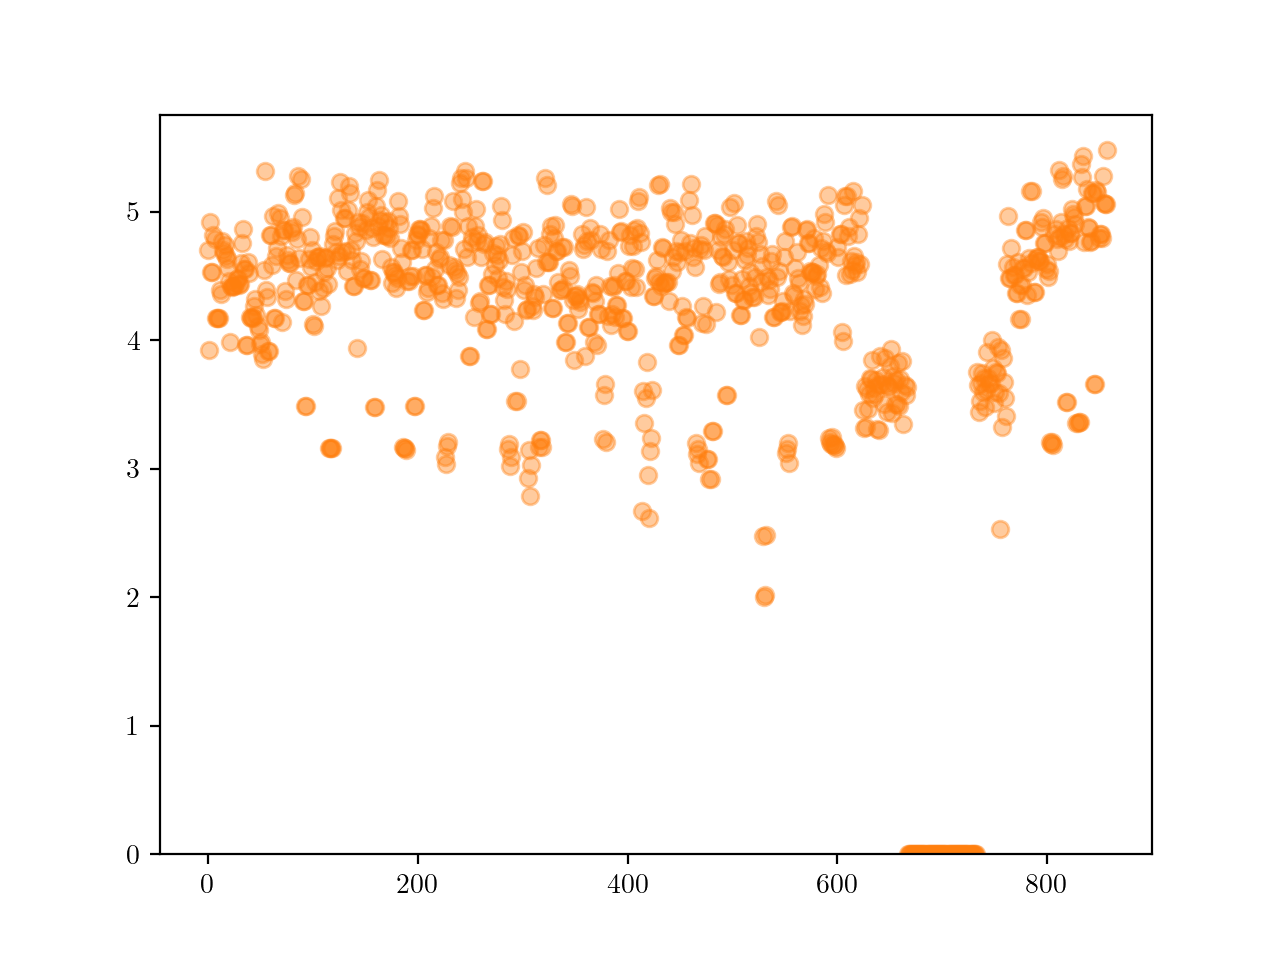

(array([0.40740741, 0.        , 0.        , 0.81481481, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        2.44444444]),
 array([-3.        , -2.72727273, -2.45454545, -2.18181818, -1.90909091,
        -1.63636364, -1.36363636, -1.09090909, -0.81818182, -0.54545455,
        -0.27272727,  0.        ]),
 <BarContainer object of 11 artists>)

In [54]:
hist(w,bins=11,density=True)